In [1]:
# plotting / charting  
import matplotlib
import matplotlib.pyplot as plt

import pylab

# numeric manipulation
import numpy as np

import pandas as pd

from keras.utils.np_utils import to_categorical

from scipy.ndimage import gaussian_filter1d

from imblearn.over_sampling import SMOTE

# CNN
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.models import Sequential
from sklearn.utils import shuffle
from keras.optimizers import SGD
from sklearn.metrics import *

Using TensorFlow backend.


In [2]:
# enable display of charts
%matplotlib inline

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import pylab
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred):
    # compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cmap=plt.cm.Blues
    title = 'Confusion matrix'    
    classes = ["non-exo", "exo"]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt =  'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

In [4]:
def plot_data(data, lables=None):
    fig = plt.figure(figsize = (25, 7));
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title("Time", fontsize = 14)
    ax.set_xlabel("ticks")
    ax.set_ylabel("flux")
       
    for d in data:
        plt.plot(d)
        
    plt.grid()
    ax.legend(lables)
    fig.tight_layout()

### import data

In [5]:
train_df = pd.read_csv('data/exoTrain.csv')
test_df = pd.read_csv('data/exoTest.csv')

X_train_valid = train_df.drop(["LABEL"], axis=1).values
y_train_valid = train_df[["LABEL"]].values 

X_test = test_df.drop(["LABEL"], axis=1).values
y_test = test_df[["LABEL"]].values

# combine both datasets into one 
exo_df = train_df.append(test_df)

In [6]:
# visualise a sample of the dataset
exo_df.head(n=5)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


### Data Exploration

# Exoplanets:		42
# Non-Exoplanets:	5615
# Total:		5657


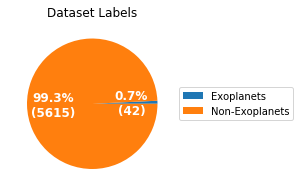

In [7]:
num_exo = exo_df[exo_df['LABEL'] == 2].shape[0]
num_non_exo = exo_df[exo_df['LABEL'] == 1].shape[0]

print('# Exoplanets:\t\t%s' % num_exo)
print('# Non-Exoplanets:\t%s' % num_non_exo)
print('# Total:\t\t%s' % (num_exo + num_non_exo))

labels = 'Exoplanets', 'Non-Exoplanets'
sizes = [num_exo, num_non_exo]
explode = [0.1, 0]

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))  
    

    return "{:.1f}%\n({:d})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(sizes, autopct=lambda pct: func(pct, sizes),
                                  textprops=dict(color="w"))

ax.legend(wedges, labels,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Dataset Labels")

plt.show()

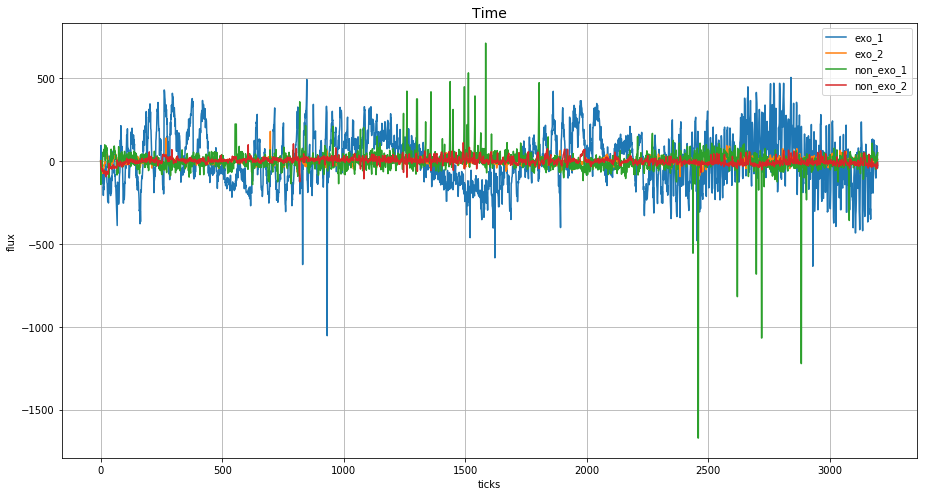

In [8]:
# select an initial trace of flux values
ts_1 = exo_df[exo_df['LABEL'] == 2].iloc[0].values
ts_2 = exo_df[exo_df['LABEL'] == 2].iloc[17].values

ts_3 = exo_df[exo_df['LABEL'] == 1].iloc[0].values
ts_4 = exo_df[exo_df['LABEL'] == 1].iloc[17].values


labels = ['exo_1', 'exo_2', 'non_exo_1', 'non_exo_2']
plot_data([ts_1, ts_2, ts_3, ts_4], labels)


### Data Pre-Processing

In [9]:
# https://en.wikipedia.org/wiki/Feature_scaling- see Standardization
# https://scikit-learn.org/stable/modules/preprocessing.html
from sklearn import preprocessing
# smooth data
from scipy.ndimage import gaussian_filter1d

def preprocess_data(data):
    """
    Prepares time series data for processing.
    """    
    processed_data = np.array([np.array(preprocessing.scale(series)) for series in data])
    
    
    return processed_data

In [10]:
# apply standardisation to each series
X_train_valid = preprocess_data(X_train_valid)
X_test = preprocess_data(X_test)

In [11]:
# one-hot encode y labels
y_train_valid = (y_train_valid - 1).flatten()
y_test = (y_test - 1).flatten()
print(sum(y_train_valid))
print(sum(y_test))

37
5


### Metrics

In [12]:
from sklearn.metrics import precision_score,recall_score, f1_score

def score_model(y_true, y_prediction):
    precision = precision_score(y_true, y_prediction)
    recall = recall_score(y_true, y_prediction)
    f1 = f1_score(y_true, y_prediction)
    print("Scores:\n-------")    
    print("Precision:\t%f" % precision)
    print("Recall:\t\t%f" % recall)
    print("F1:\t\t%f" % f1)

### Benchmark Model - Supervised Learning

In [13]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, ShuffleSplit

In [14]:
dtc = DecisionTreeClassifier()
ada_model = AdaBoostClassifier(dtc) 

params = {"base_estimator__criterion" : ["gini", "entropy"], "base_estimator__min_samples_leaf": [1,2] }

score_fn = make_scorer(recall_score)    

grid = GridSearchCV(estimator=ada_model, param_grid=params, scoring=score_fn, cv=3, verbose=3)
grid = grid.fit(X_train_valid[:1200], y_train_valid[:1200])
grid.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] base_estimator__criterion=gini, base_estimator__min_samples_leaf=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  base_estimator__criterion=gini, base_estimator__min_samples_leaf=1, score=0.3076923076923077, total=   2.6s
[CV] base_estimator__criterion=gini, base_estimator__min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV]  base_estimator__criterion=gini, base_estimator__min_samples_leaf=1, score=0.16666666666666666, total=   3.0s
[CV] base_estimator__criterion=gini, base_estimator__min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s


[CV]  base_estimator__criterion=gini, base_estimator__min_samples_leaf=1, score=0.08333333333333333, total=   2.8s
[CV] base_estimator__criterion=gini, base_estimator__min_samples_leaf=2 
[CV]  base_estimator__criterion=gini, base_estimator__min_samples_leaf=2, score=0.0, total=  40.3s
[CV] base_estimator__criterion=gini, base_estimator__min_samples_leaf=2 
[CV]  base_estimator__criterion=gini, base_estimator__min_samples_leaf=2, score=0.0, total=  40.9s
[CV] base_estimator__criterion=gini, base_estimator__min_samples_leaf=2 
[CV]  base_estimator__criterion=gini, base_estimator__min_samples_leaf=2, score=0.08333333333333333, total=  44.1s
[CV] base_estimator__criterion=entropy, base_estimator__min_samples_leaf=1 
[CV]  base_estimator__criterion=entropy, base_estimator__min_samples_leaf=1, score=0.15384615384615385, total=   2.7s
[CV] base_estimator__criterion=entropy, base_estimator__min_samples_leaf=1 
[CV]  base_estimator__criterion=entropy, base_estimator__min_samples_leaf=1, score=

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  5.4min finished
/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)

Scores:
-------
Precision:	0.045455
Recall:		0.200000
F1:		0.074074


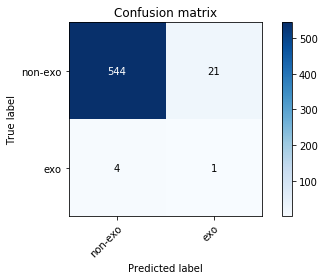

In [15]:
y_pred = grid.best_estimator_.predict(X_test)
# display results
plot_confusion_matrix(y_test, y_pred)
score_model(y_test, y_pred)

### Util Methods

In [17]:
def sub_selection (X, y, size):
    """
    Subselects data and includes all positives samples in the output dataset.
    """
    x_pos = X[y == 1]
    x_neg = X[y == 0]
    
    X_output = np.vstack([x_pos, x_neg])
    y_output = np.hstack([np.ones(len(x_pos)), np.zeros(len(x_neg))])
    
    return X_output[:size], y_output[:size]

def reshape_X_tensor(X):
    """
    Common reshape function that is used to transform 2D matrix. 
    """
    return X.reshape(X.shape[0], X.shape[1], 1)

def display_tensor_attributes(X, y):
    """
    Displays useful information about the input tensors.
    """  
    print("X Size: %s" % str(X.shape))
    print("Y Size: %d" % len(y))
    print("Positive Samples: %d" % sum(y))

### Split data into train / valid / test

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.3, random_state=7, stratify=y_train_valid)

print("Exoplanets in train: %d" % sum(y_train))
print("Exoplanets in valid: %d" % sum(y_valid))
print("Exoplanets in test: %d" % sum(y_test))

Exoplanets in train: 26
Exoplanets in valid: 11
Exoplanets in test: 5


In [19]:
X_to_valid = reshape_X_tensor(X_valid)
display_tensor_attributes(X_to_valid, y_valid)

X Size: (1527, 3197, 1)
Y Size: 1527
Positive Samples: 11


### Augment Number of Training Exoplanets

### Default Sample

In [23]:
# sub-select data including all positives samples
X_default_train, y_default_train = sub_selection(X_train, y_train, 1200)

# reshape data for CNN
X_default_train = reshape_X_tensor(X_default_train)

In [24]:
# validate the input to CNN
display_tensor_attributes(X_default_train, y_default_train)

X Size: (1200, 3197, 1)
Y Size: 1200
Positive Samples: 26


### Simple Oversampling

In [25]:
def simple_oversample(X, y, repeat_pos=2):
    # oversample all positive data for training only
    positives = X[y == 1]
    X_pos = positives

    ## 
    X_new = np.array(X_pos)
    for i in range(1,repeat_pos):
        X_new = np.vstack([X_new, X_pos])
    
    X_new = np.vstack([X_new, X])
    
    y_new = np.hstack([np.ones(len(X_pos)*repeat_pos),  y])
    return X_new, y_new

In [26]:
X_simple_oversample, y_simple_oversample = simple_oversample(X_train, y_train, repeat_pos=2)

# sub-select data including all positives samples
X_simple_oversample_train, y_simple_oversample_train = sub_selection(X_simple_oversample, y_simple_oversample, 1200)

# reshape data for CNN
X_simple_oversample_train = reshape_X_tensor(X_simple_oversample_train)


In [27]:
# validate the input to CNN
display_tensor_attributes(X_simple_oversample_train, y_simple_oversample_train)

X Size: (1200, 3197, 1)
Y Size: 1200
Positive Samples: 78


### SMOTE - Synthetic Minority Over-Sampling Technquie

In [28]:
oversampler = SMOTE(random_state=2)
# Create unique synthetic positive samples within the dataset. 
# The new samples are generated so they closely resemble other positive
# samples in the set.
# This attempts to address the natural imbalance within the original data.
X_train_res, y_train_res = oversampler.fit_sample(X_train, y_train.ravel())

X_smote_train = reshape_X_tensor(X_train_res)
y_smote_train = y_train_res

display_tensor_attributes(X_smote_train, y_smote_train)

X Size: (7068, 3197, 1)
Y Size: 7068
Positive Samples: 3534


### Model Architecture

In [29]:
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from keras.optimizers import SGD
from sklearn.metrics import *

In [30]:
model = Sequential()

# convolutional layers
model.add(Convolution1D(64, 5, input_shape=(3197,1), activation = 'relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.5))

model.add(Convolution1D(32, 25, activation='relu'))
model.add(Dropout(0.6))

# flatten layer
model.add(Flatten())

# dense layer
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 3193, 64)          384       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1596, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1596, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1572, 32)          51232     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1572, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50304)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 50305     
Total para

In [31]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
# default sample
checkpointer = ModelCheckpoint(filepath='default.sample.hdf5', verbose=1, save_best_only=True)

simple_history = model.fit(X_default_train, y_default_train,
          validation_data=(X_to_valid, y_valid),
          batch_size = 120, epochs = 10,callbacks=[checkpointer], verbose = 1)

Train on 1200 samples, validate on 1527 samples
Epoch 1/10
1200/1200 [==============================] - 35s - loss: 0.2078 - acc: 0.9233 - val_loss: 0.3120 - val_acc: 0.9928
Epoch 2/10
1200/1200 [==============================] - 35s - loss: 0.1204 - acc: 0.9783 - val_loss: 0.0514 - val_acc: 0.9928
Epoch 3/10
1200/1200 [==============================] - 35s - loss: 0.0954 - acc: 0.9783 - val_loss: 0.0550 - val_acc: 0.9928
Epoch 4/10
1200/1200 [==============================] - 35s - loss: 0.0879 - acc: 0.9783 - val_loss: 0.0620 - val_acc: 0.9928
Epoch 5/10
1200/1200 [==============================] - 35s - loss: 0.0820 - acc: 0.9783 - val_loss: 0.0677 - val_acc: 0.9928
Epoch 6/10
1200/1200 [==============================] - 35s - loss: 0.0763 - acc: 0.9783 - val_loss: 0.0610 - val_acc: 0.9928
Epoch 7/10
1200/1200 [==============================] - 35s - loss: 0.0699 - acc: 0.9783 - val_loss: 0.0444 - val_acc: 0.9928
Epoch 8/10
1200/1200 [==============================] - 35s - loss: 0.

Scores:
-------
Precision:	0.000000
Recall:		0.000000
F1:		0.000000


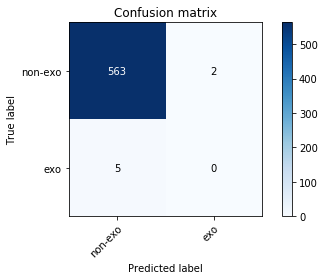

In [33]:
model.load_weights('default.sample.hdf5')
y_predictions = model.predict(reshape_X_tensor(X_test))

# display results
plot_confusion_matrix(y_test, np.round(y_predictions))
score_model(y_test, np.round(y_predictions))

In [40]:
# simple oversample
checkpointer = ModelCheckpoint(filepath='simple.oversample.hdf5', verbose=1, save_best_only=True)

simple_history = model.fit(X_simple_oversample_train, y_simple_oversample_train,
          validation_data=(X_to_valid, y_valid),
          batch_size = 120, epochs = 10,callbacks=[checkpointer], verbose = 1)

Train on 1200 samples, validate on 1527 samples
Epoch 1/10
1200/1200 [==============================] - 35s - loss: 0.3622 - acc: 0.8733 - val_loss: 0.1312 - val_acc: 0.9928
Epoch 2/10
1200/1200 [==============================] - 35s - loss: 0.2286 - acc: 0.9350 - val_loss: 0.1517 - val_acc: 0.9928
Epoch 3/10
1200/1200 [==============================] - 34s - loss: 0.1975 - acc: 0.9350 - val_loss: 0.0516 - val_acc: 0.9928
Epoch 4/10
1200/1200 [==============================] - 35s - loss: 0.1620 - acc: 0.9358 - val_loss: 0.1018 - val_acc: 0.9915
Epoch 5/10
1200/1200 [==============================] - 35s - loss: 0.1230 - acc: 0.9425 - val_loss: 0.0590 - val_acc: 0.9876
Epoch 6/10
1200/1200 [==============================] - 35s - loss: 0.0841 - acc: 0.9683 - val_loss: 0.0400 - val_acc: 0.9902
Epoch 7/10
1200/1200 [==============================] - 35s - loss: 0.0549 - acc: 0.9825 - val_loss: 0.0366 - val_acc: 0.9882
Epoch 8/10
1200/1200 [==============================] - 35s - loss: 0.

Scores:
-------
Precision:	0.333333
Recall:		0.200000
F1:		0.250000


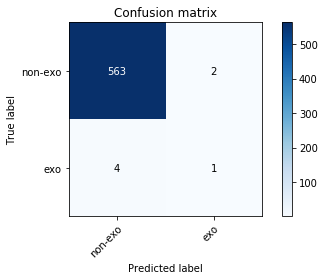

In [41]:
model.load_weights('simple.oversample.hdf5')
y_predictions = model.predict(reshape_X_tensor(X_test))

# display results
plot_confusion_matrix(y_test, np.round(y_predictions))
score_model(y_test, np.round(y_predictions))

In [42]:
# SMOTE
checkpointer = ModelCheckpoint(filepath='smote.oversample.hdf5', verbose=1, save_best_only=True)

svn_history = model.fit(X_smote_train, y_smote_train,
          validation_data=(X_to_valid, y_valid),
          batch_size = 120, epochs = 10, callbacks=[checkpointer], verbose = 1)

Train on 7068 samples, validate on 1527 samples
Epoch 1/10
7068/7068 [==============================] - 157s - loss: 0.0226 - acc: 0.9943 - val_loss: 0.0308 - val_acc: 0.9915
Epoch 2/10
7068/7068 [==============================] - 157s - loss: 0.0076 - acc: 0.9982 - val_loss: 0.0332 - val_acc: 0.9915
Epoch 3/10
7068/7068 [==============================] - 157s - loss: 0.0037 - acc: 0.9990 - val_loss: 0.0285 - val_acc: 0.9935
Epoch 4/10
7068/7068 [==============================] - 157s - loss: 0.0025 - acc: 0.9994 - val_loss: 0.0302 - val_acc: 0.9935
Epoch 5/10
7068/7068 [==============================] - 157s - loss: 0.0015 - acc: 0.9997 - val_loss: 0.0308 - val_acc: 0.9928
Epoch 6/10
7068/7068 [==============================] - 157s - loss: 0.0010 - acc: 0.9999 - val_loss: 0.0336 - val_acc: 0.9935
Epoch 7/10
7068/7068 [==============================] - 157s - loss: 0.0012 - acc: 0.9999 - val_loss: 0.0368 - val_acc: 0.9915
Epoch 8/10
7068/7068 [==============================] - 157s - 

Scores:
-------
Precision:	0.500000
Recall:		0.600000
F1:		0.545455


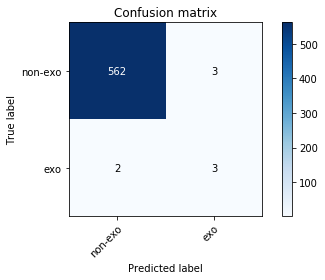

In [43]:
model.load_weights('smote.oversample.hdf5')
y_predictions = model.predict(reshape_X_tensor(X_test))

# display results
plot_confusion_matrix(y_test, np.round(y_predictions))
score_model(y_test, np.round(y_predictions))

---

## Overall Results:

|Model|Precision|Recall|F1|
|---|---|---|---|
|AdaBoost_benchmark|0.045455|0.200000|0.074074|
|initial_cnn|0.000000|0.000000|0.000000|
|cnn_simple_oversample|0.333333|0.200000|0.250000|
|cnn_smote_oversample|0.500000|0.600000|0.545455|

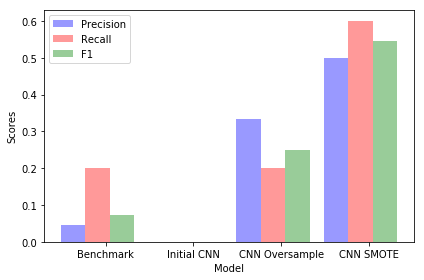

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
n_groups = 4

precision = (0.045455, 0.0, 0.333333, 0.500000)
recall = (0.200, 0.00, 0.200, 0.600)
f1 = (0.074074, 0.00000, 0.250, 0.545455)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.28

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, precision, bar_width,
                alpha=opacity, color='b',
                label='Precision')

rects2 = ax.bar(index + bar_width, recall, bar_width,
                alpha=opacity, color='r',
                label='Recall')

rects3 = ax.bar(index + bar_width+ bar_width, f1, bar_width,
                alpha=opacity, color='g',
                label='F1')

ax.set_xlabel('Model')
ax.set_ylabel('Scores')
ax.set_title('')
ax.set_xticks(index + bar_width + bar_width / 3)
ax.set_xticklabels(('Benchmark', 'Initial CNN', 'CNN Oversample', 'CNN SMOTE'))
ax.legend()

fig.tight_layout()
plt.show()